In [12]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!cp -r "/content/drive/MyDrive/OCR-DNN/data" "/content/data"

In [23]:
# Dataset base directory inside Drive
BASE_DATA_DIR = "/content/drive/MyDrive/OCR-DNN/data"

TRAIN_DIR = os.path.join(BASE_DATA_DIR, "training_data")
TEST_DIR = os.path.join(BASE_DATA_DIR, "testing_data")

print("Train directory:", TRAIN_DIR)
print("Test directory:", TEST_DIR)


Train directory: /content/drive/MyDrive/OCR-DNN/data/training_data
Test directory: /content/drive/MyDrive/OCR-DNN/data/testing_data


In [24]:
def sorted_classes(path):
    classes = [c for c in os.listdir(path) if not c.startswith('.')]
    return sorted(classes)

print("Sorted classes:", sorted_classes(TRAIN_DIR))


Sorted classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [25]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # small square image
    transforms.Grayscale(num_output_channels=1), # converts to 1 channel
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
train_path = "/content/data/training_data"
test_path = "/content/data/testing_data"

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# inspect
print("classes:", train_dataset.classes)
print("class_to_idx:", train_dataset.class_to_idx)

classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
class_to_idx: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35}


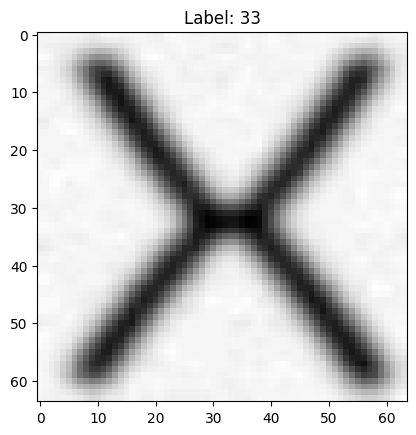

In [7]:
images, labels = next(iter(train_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class OCRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

num_classes = len(train_dataset.classes)
model = OCRCNN(num_classes)
model


OCRCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=36, bias=True)
)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [30]:
num_epochs = 10

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---- TRAINING ----
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc="Training", leave=False)

    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)


Epoch 1/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 2/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 3/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 4/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 5/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 6/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 7/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 8/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 9/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]


Epoch 10/10


Training:   0%|          | 0/646 [00:00<?, ?it/s]

In [31]:
    # ---- TESTING ----
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing", leave=False)

        for imgs, labels in test_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_test_loss = running_loss / len(test_loader)
    epoch_test_acc = 100 * correct / total
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    # ---- PRINT SUMMARY ----
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
    print(f"Test Loss:  {epoch_test_loss:.4f} | Test Acc:  {epoch_test_acc:.2f}%")


Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0377 | Train Acc: 98.55%
Test Loss:  0.0302 | Test Acc:  98.81%


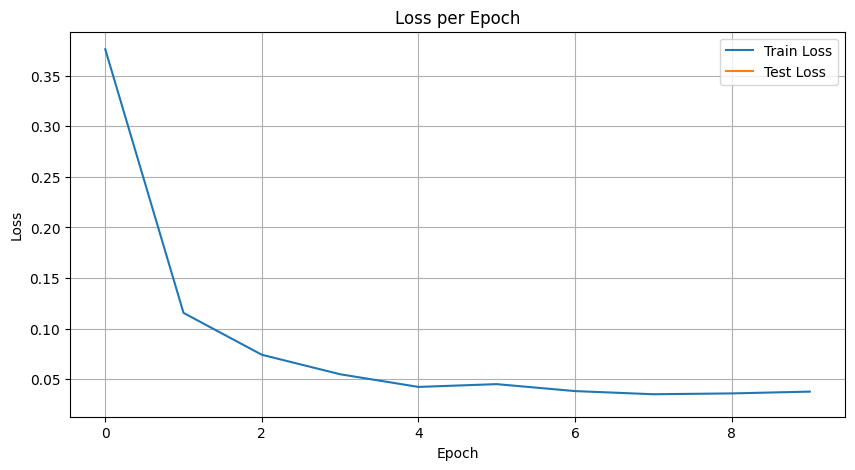

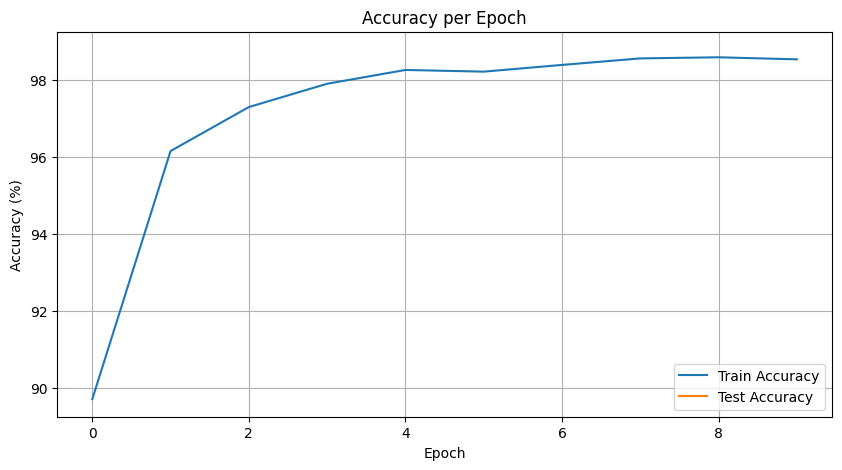

In [32]:
# --- LOSS ---
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# --- ACCURACY ---
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()
